In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Add, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam


import seaborn as sns
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

!pip install patchify
from patchify import patchify
from PIL import Image
# import segmentation_models as sm
from IPython.display import HTML
from base64 import b64encode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
original_data_dir = "/content/drive/MyDrive/dataset/original_images"
semantic_data_dir = "/content/drive/MyDrive/dataset/label_images_semantic"
rgb_data_dir = "/content/drive/MyDrive/dataset/RGB_color_image_masks/RGB_color_image_masks/"

# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in sorted(os.listdir(folder_dir)):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
        print(images)
    return image_dataset

image_dataset = data_loader(original_data_dir) # real images...
mask_dataset = data_loader(rgb_data_dir) # masked images...



000.jpg
001.jpg
002.jpg
003.jpg
004.jpg
005.jpg
006.jpg
008.jpg
011.jpg
013.jpg
014.jpg
015.jpg
016.jpg
018.jpg
019.jpg
021.jpg
022.jpg
023.jpg
026.jpg
028.jpg
031.jpg
035.jpg
038.jpg
040.jpg
041.jpg
042.jpg
043.jpg
044.jpg
045.jpg
047.jpg
049.jpg
051.jpg
052.jpg
053.jpg
055.jpg
056.jpg
057.jpg
058.jpg
059.jpg
060.jpg
062.jpg
063.jpg
065.jpg
068.jpg
070.jpg
071.jpg
073.jpg
074.jpg
075.jpg
077.jpg
078.jpg
079.jpg
080.jpg
081.jpg
083.jpg
086.jpg
088.jpg
089.jpg
092.jpg
095.jpg
098.jpg
099.jpg
100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
106.jpg
107.jpg
109.jpg
110.jpg
111.jpg
112.jpg
113.jpg
116.jpg
117.jpg
118.jpg
119.jpg
120.jpg
121.jpg
122.jpg
123.jpg
124.jpg
126.jpg
128.jpg
130.jpg
133.jpg
134.jpg
135.jpg
136.jpg
137.jpg
138.jpg
139.jpg
140.jpg
141.jpg
145.jpg
146.jpg
147.jpg
148.jpg
149.jpg
150.jpg
153.jpg
154.jpg
155.jpg
156.jpg
157.jpg
158.jpg
159.jpg
160.jpg
161.jpg
162.jpg
163.jpg
164.jpg
165.jpg
166.jpg
167.jpg
170.jpg
171.jpg
172.jpg
173.jpg
174.jpg
175.jpg
176.jpg
177.jpg
178.jpg


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
file_names = np.sort(os.listdir(original_data_dir))
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])
print(filenames)

['000' '001' '002' '003' '004' '005' '006' '008' '011' '013' '014' '015'
 '016' '018' '019' '021' '022' '023' '026' '028' '031' '035' '038' '040'
 '041' '042' '043' '044' '045' '047' '049' '051' '052' '053' '055' '056'
 '057' '058' '059' '060' '062' '063' '065' '068' '070' '071' '073' '074'
 '075' '077' '078' '079' '080' '081' '083' '086' '088' '089' '092' '095'
 '098' '099' '100' '101' '102' '103' '104' '106' '107' '109' '110' '111'
 '112' '113' '116' '117' '118' '119' '120' '121' '122' '123' '124' '126'
 '128' '130' '133' '134' '135' '136' '137' '138' '139' '140' '141' '145'
 '146' '147' '148' '149' '150' '153' '154' '155' '156' '157' '158' '159'
 '160' '161' '162' '163' '164' '165' '166' '167' '170' '171' '172' '173'
 '174' '175' '176' '177' '178' '179' '180' '181' '182' '185' '186' '188'
 '190' '192' '193' '194' '195' '198' '199' '200' '202' '204' '206' '207'
 '208' '209' '213' '214' '215' '216' '217' '219' '220' '221' '222' '223'
 '225' '226' '228' '229' '230' '232' '233' '234' '2

In [ ]:
def linearSearch(arr, x):
    for i in range(0, len(arr)):
        if (arr[i] == x):
            return i
    return -1

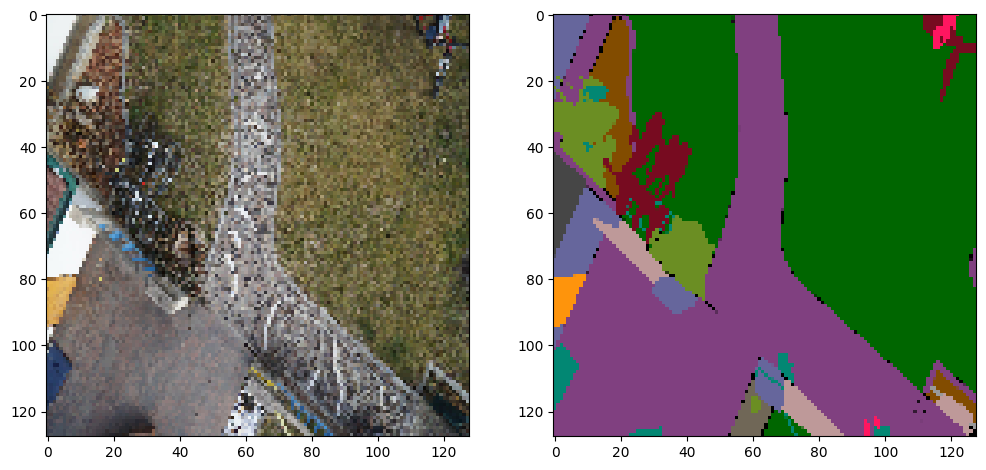

163

In [ ]:
# Sanity check...
random_filename  = random.choice(filenames)
image_number = linearSearch(filenames, random_filename)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

image_number

In [ ]:
mask_labels = pd.read_csv('/content/drive/MyDrive/dataset/class_dict_seg.csv', index_col=False, skipinitialspace=True)

mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


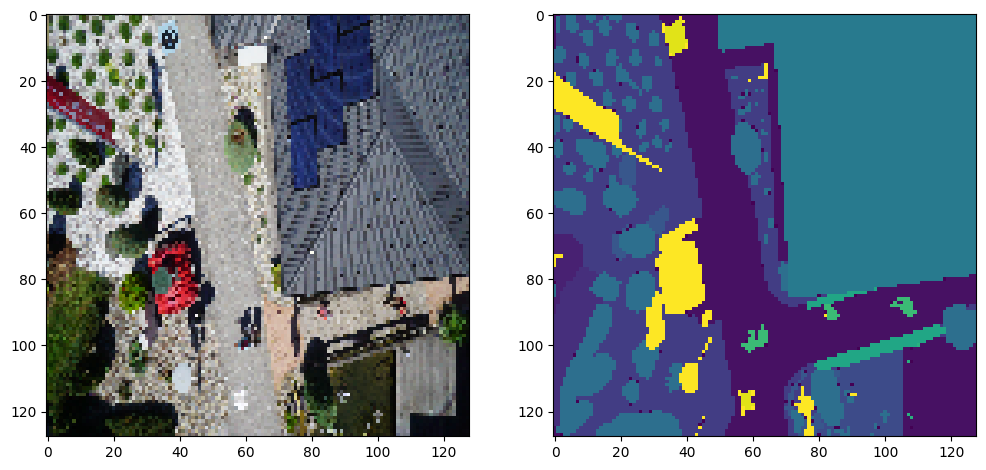

93

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
# image_number = random.randint(0, len(image_dataset))
random_filename  = random.choice(filenames)
image_number = linearSearch(filenames, random_filename)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

image_number

In [ ]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

# **Build Model**

In [ ]:


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Step 1: Import ResNet and Build the Backbone
We will use the pre-trained ResNet50 model as the encoder and add decoder layers for the segmentation task.


In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

def resnet152_unet(input_shape, n_classes):
    # Load ResNet152 as the backbone
    resnet152 = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

    # Extract layers from ResNet152 for skip connections
    layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block8_out', 'conv4_block36_out', 'conv5_block3_out']
    layers = [resnet152.get_layer(name).output for name in layer_names]

    # Create the U-Net decoder
    x = layers[-1]
    for i in range(4, 0, -1):
        x = UpSampling2D(size=(2, 2))(x)
        x = Concatenate()([x, layers[i-1]])
        x = Conv2D(256 // (2**(4-i)), (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(256 // (2**(4-i)), (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, resnet152.input])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    output = Conv2D(n_classes, (1, 1), activation='softmax')(x)

    # Create the model
    model = Model(inputs=resnet152.input, outputs=output)

    return model

# Define the model
input_shape = (128, 128, 3)
n_classes = 23
model = resnet152_unet(input_shape, n_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Step 2: Compile the Model
We will compile the model with a suitable optimizer, loss function, and metrics.


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=n_classes)])


### Step 3: Train the Model
We will set up some callbacks for saving the best model and early stopping.


In [ ]:
# Set up callbacks
checkpoint = ModelCheckpoint('resnet50_unet.h5', save_best_only=True, monitor='val_loss', mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=75,
                    batch_size=8,
                    callbacks=[checkpoint])


Epoch 1/75
40/40 [==============================] - ETA: 0s - loss: 8.4079 - accuracy: 0.2491 - mean_io_u: 0.4783

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 149s 740ms/step - loss: 8.4079 - accuracy: 0.2491 - mean_io_u: 0.4783 - val_loss: 3.8154 - val_accuracy: 0.2946 - val_mean_io_u: 0.4783
Epoch 2/75
40/40 [==============================] - 20s 509ms/step - loss: 3.1121 - accuracy: 0.4174 - mean_io_u: 0.4783 - val_loss: 2.5121 - val_accuracy: 0.4556 - val_mean_io_u: 0.4783
Epoch 3/75
40/40 [==============================] - 28s 704ms/step - loss: 2.4531 - accuracy: 0.4886 - mean_io_u: 0.4783 - val_loss: 2.2554 - val_accuracy: 0.5094 - val_mean_io_u: 0.4783
Epoch 4/75
40/40 [==============================] - 27s 696ms/step - loss: 2.0535 - accuracy: 0.5381 - mean_io_u: 0.4783 - val_loss: 1.8751 - val_accuracy: 0.5407 - val_mean_io_u: 0.4783
Epoch 5/75
40/40 [==============================] - 27s 681ms/step - loss: 1.7706 - accuracy: 0.5767 - mean_io_u: 0.4783 - val_loss: 1.6800 - val_accuracy: 0.5937 - val_mean_io_u: 0.4783
Epoch 6/75
40/40 [==============================] - 8s 208ms/step - loss: 1

### Step 4: Evaluate the Model
After training, evaluate the model on the test set.


In [ ]:
# Evaluate the model
loss, accuracy, mean_iou = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Mean IoU: {mean_iou}")


3/3 [==============================] - 10s 1s/step - loss: 0.9158 - accuracy: 0.7909 - mean_io_u: 0.5126
Test Loss: 0.9157560467720032
Test Accuracy: 0.7909347414970398
Test Mean IoU: 0.512599766254425


### Step 5: Visualize Results
Visualize some predictions to see how well the model performs.


1/1 [==============================] - 5s 5s/step


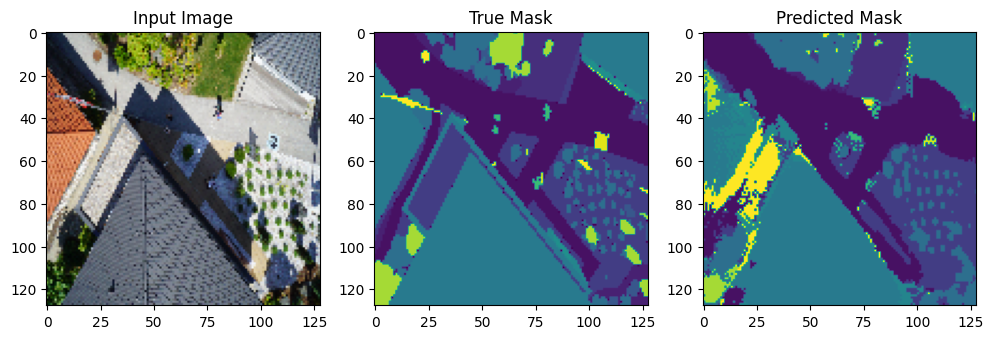

1/1 [==============================] - 0s 48ms/step


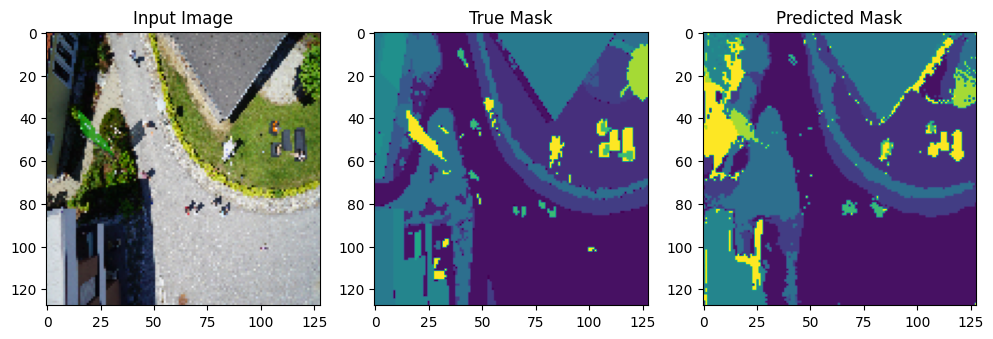

1/1 [==============================] - 0s 38ms/step


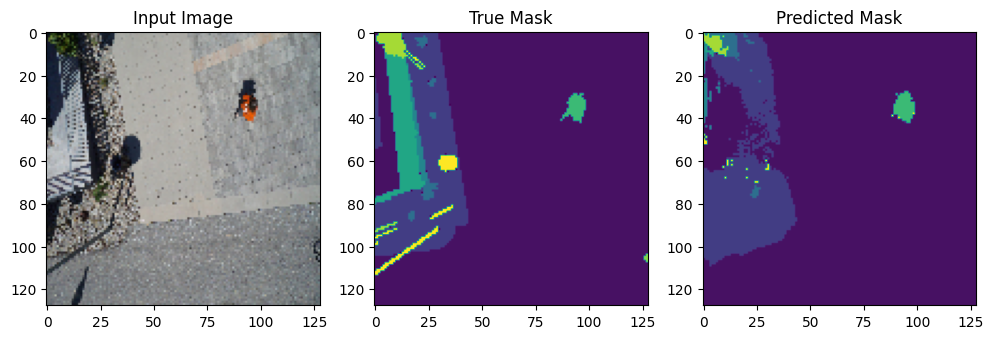

1/1 [==============================] - 0s 37ms/step


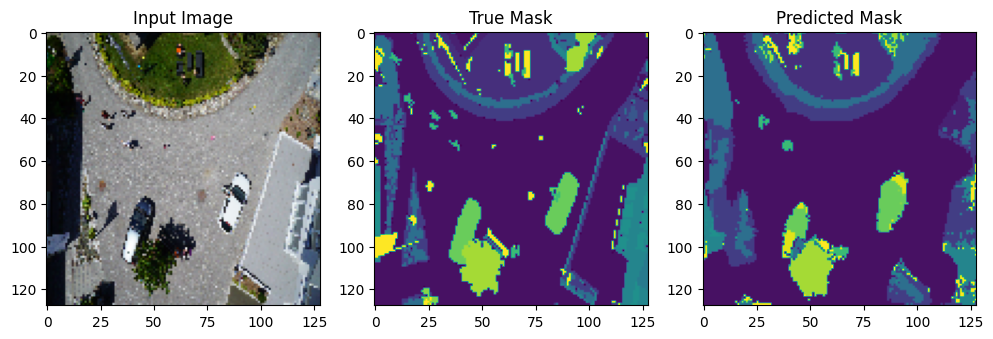

1/1 [==============================] - 0s 58ms/step


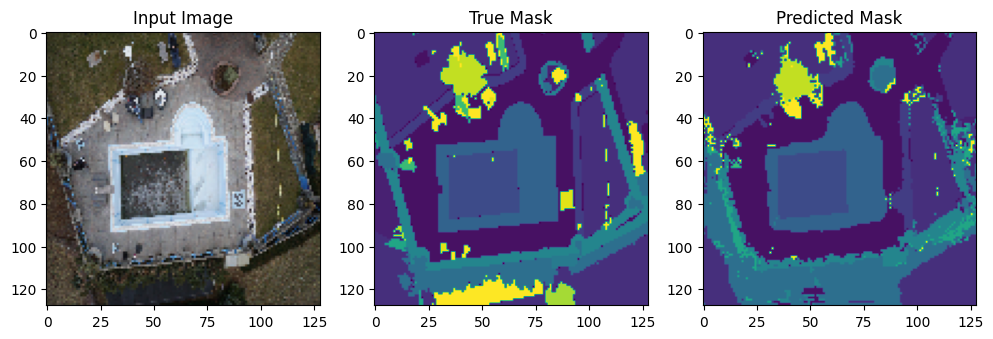

In [ ]:
# Visualize some predictions
def visualize_predictions(model, X_test, y_test, num_images=5):
    for i in range(num_images):
        idx = random.randint(0, len(X_test) - 1)
        img = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img)
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(np.argmax(true_mask, axis=-1))
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(np.argmax(pred_mask, axis=-1))
        plt.show()

# Visualize predictions
visualize_predictions(model, X_test, y_test)
